<a href="https://colab.research.google.com/github/Jean-Paulo-Public/probability-sandbox/blob/main/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

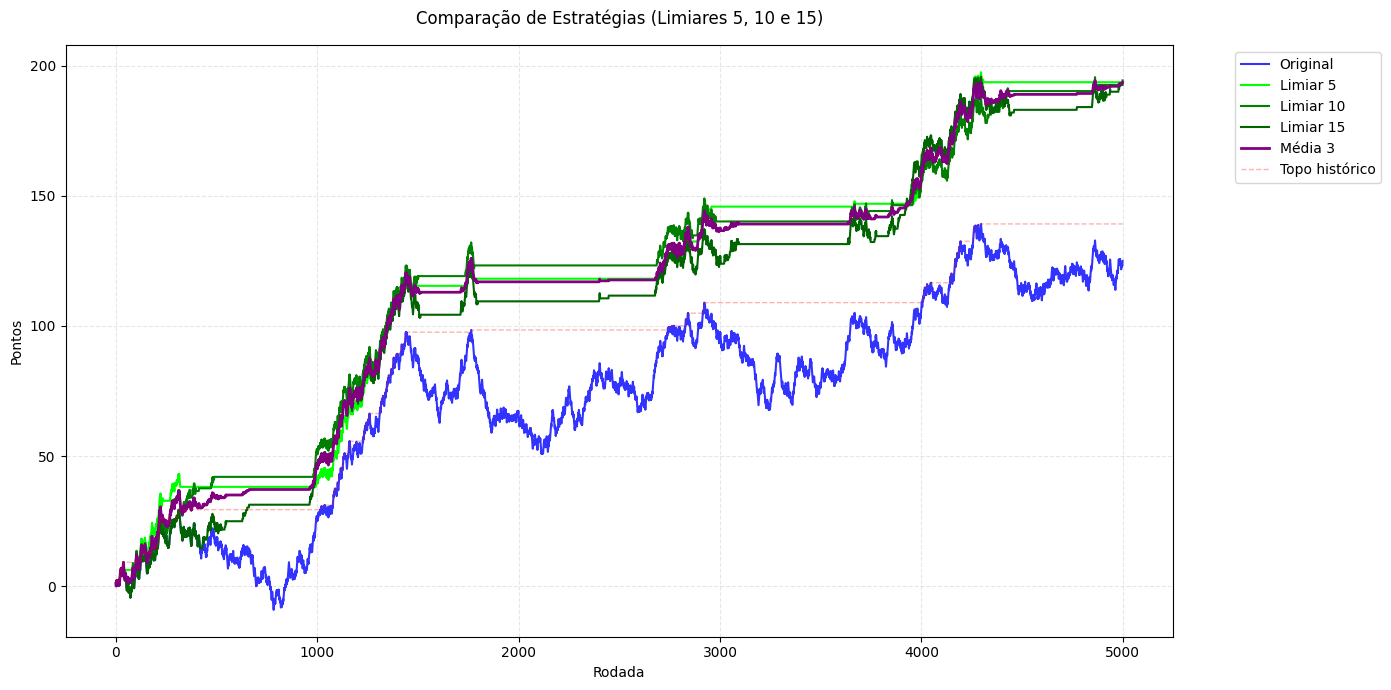

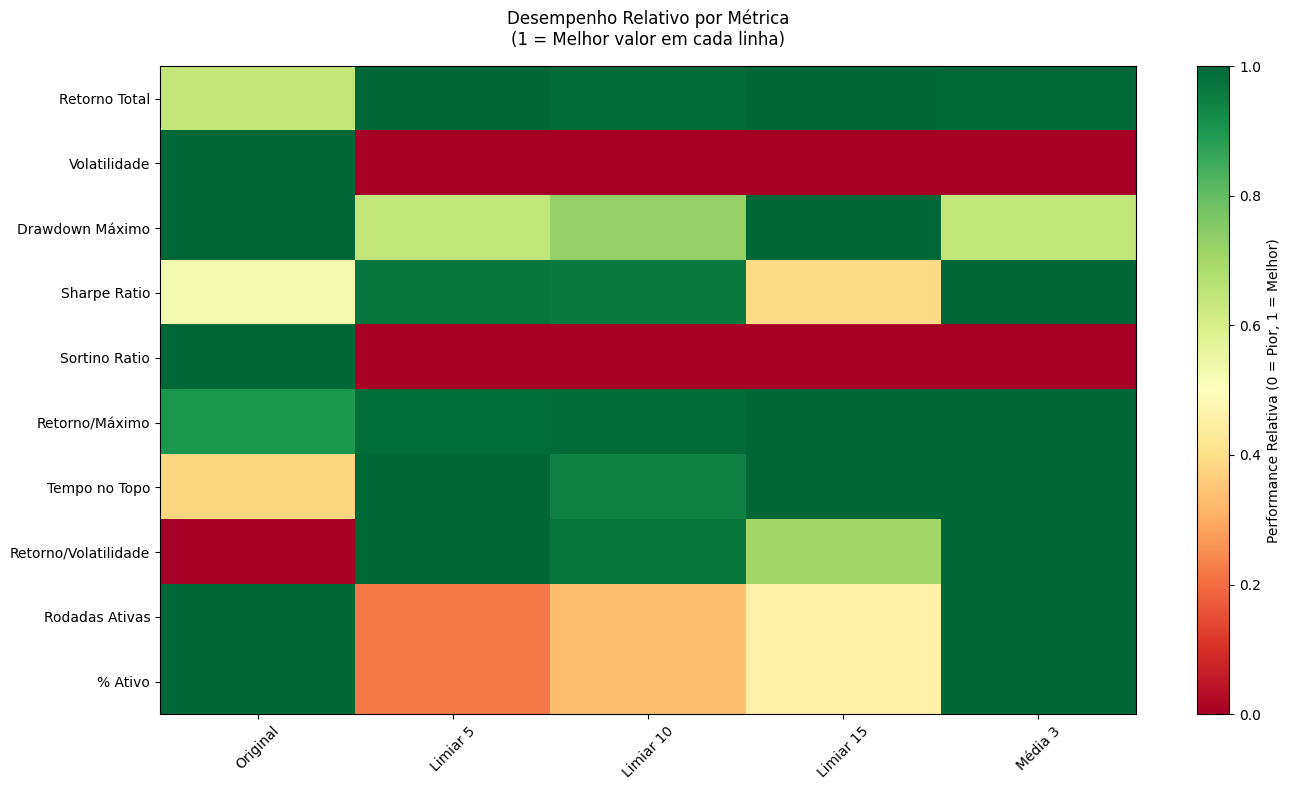

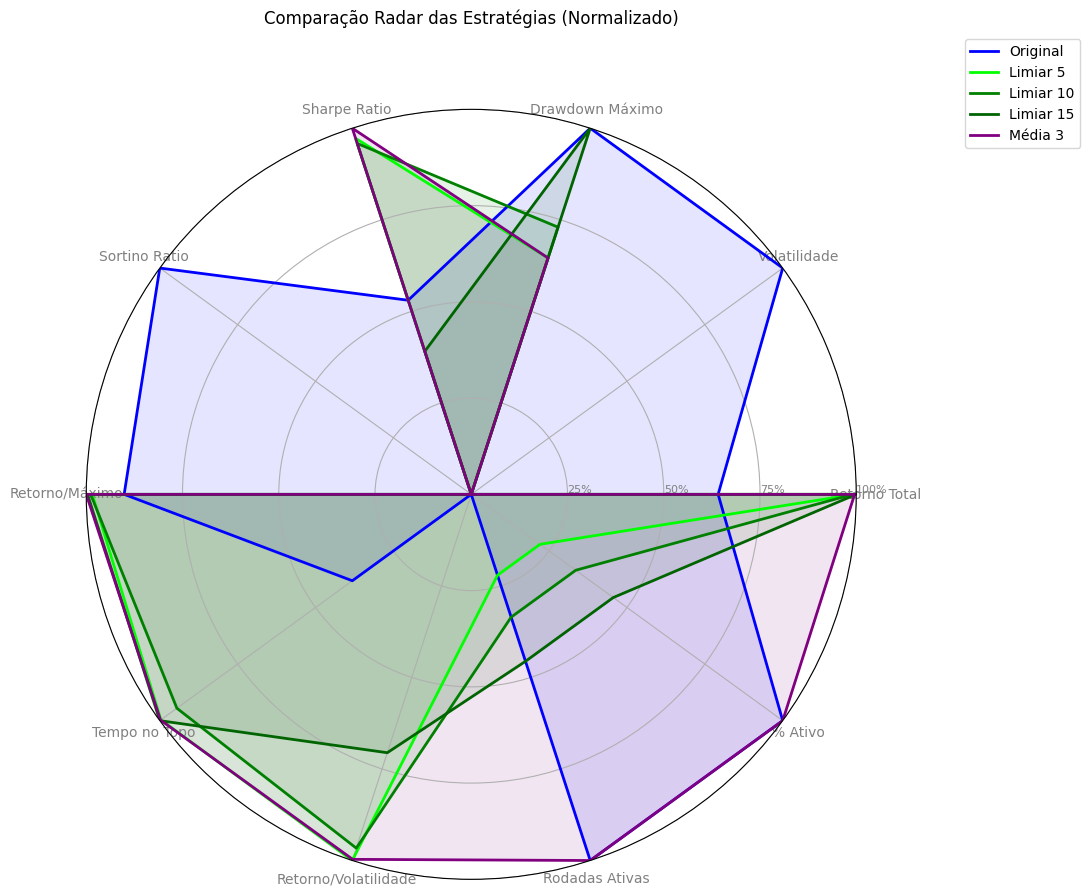

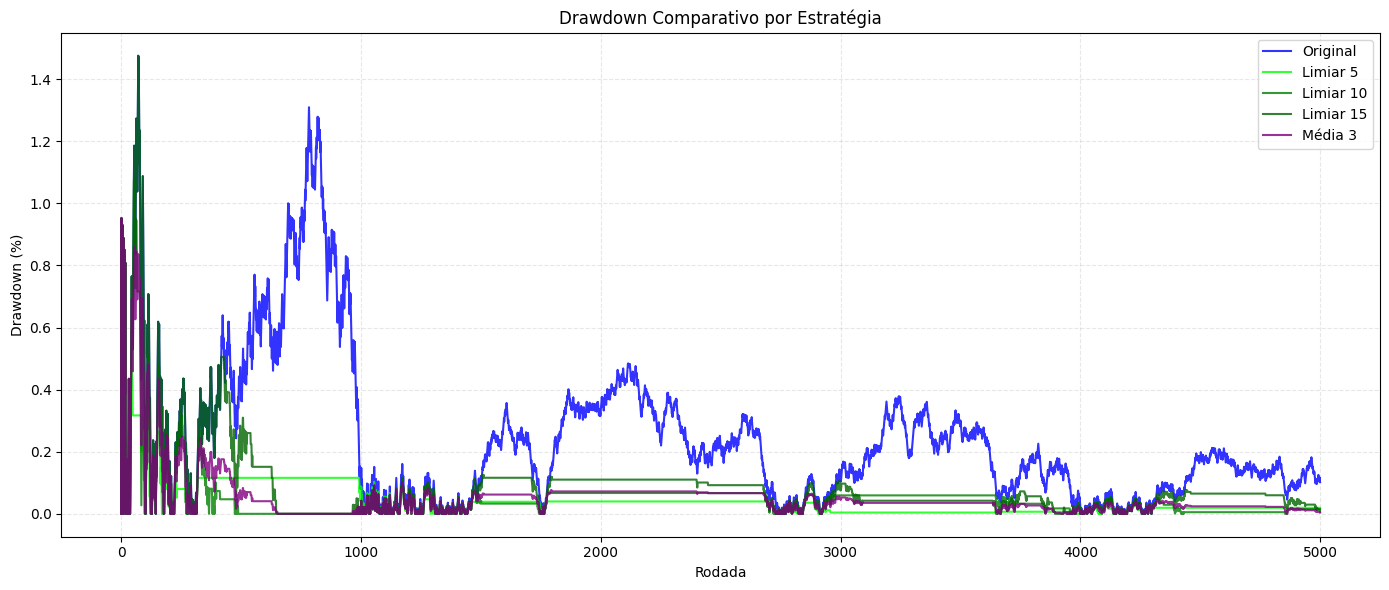


📊 ANÁLISE COMPARATIVA DAS ESTRATÉGIAS
+----------------------+----------------+------------+-------------+-------------+-----------+
|                      |       Original |   Limiar 5 |   Limiar 10 |   Limiar 15 |   Média 3 |
+======================+================+============+=============+=============+===========+
|    Retorno Total     |         123.95 |     192.60 |      191.55 |      193.30 |    192.48 |
+----------------------+----------------+------------+-------------+-------------+-----------+
|     Volatilidade     | 10480359005.35 |      23.19 |       23.87 |       32.98 |     23.25 |
+----------------------+----------------+------------+-------------+-------------+-----------+
|   Drawdown Máximo    |           1.48 |       0.95 |        1.08 |        1.48 |      0.95 |
+----------------------+----------------+------------+-------------+-------------+-----------+
|     Sharpe Ratio     |           0.01 |       0.03 |        0.03 |        0.01 |      0.03 |
+----------

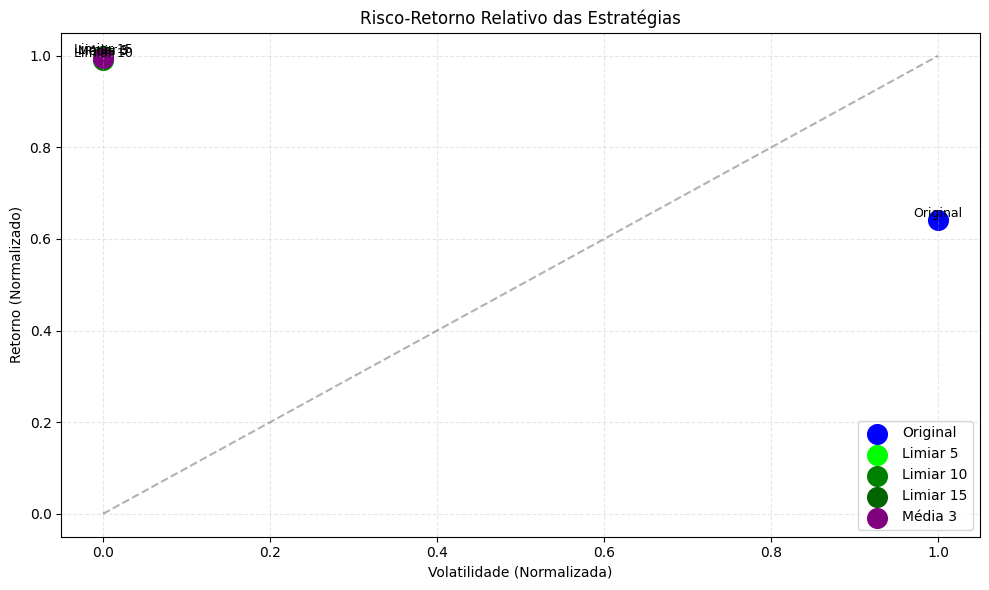

In [3]:
import secrets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Configurações
num_rodadas = 5000
ponto_cara = 1.05
ponto_coroa = -1

# Inicialização
pontos = 0
evolucao_pontos = []
topo_historico = []

# Estratégias (apenas 5, 10 e 15)
estrategias = {
    'Original': {'pontos': 0, 'evolucao': [], 'congelamentos': 0, 'cor': 'blue'},
    'Limiar 5': {'pontos': 0, 'evolucao': [], 'congelamentos': 0, 'cor': 'lime'},
    'Limiar 10': {'pontos': 0, 'evolucao': [], 'congelamentos': 0, 'cor': 'green'},
    'Limiar 15': {'pontos': 0, 'evolucao': [], 'congelamentos': 0, 'cor': 'darkgreen'}
}

# Simulação
for rodada in range(num_rodadas):
    # Jogo original
    resultado = secrets.SystemRandom().random()
    pontos += ponto_cara if resultado < 0.5 else ponto_coroa
    evolucao_pontos.append(pontos)
    topo_historico.append(max(topo_historico[-1], pontos) if rodada > 0 else pontos)

    # Atualização das estratégias
    for nome, dados in estrategias.items():
        if nome == 'Original':
            dados['pontos'] = pontos
            dados['evolucao'].append(pontos)
            continue

        limiar = int(nome.split()[-1])
        diferenca = topo_historico[-1] - pontos

        if diferenca <= limiar:
            dados['pontos'] += ponto_cara if resultado < 0.5 else ponto_coroa
        else:
            dados['congelamentos'] += 1

        dados['evolucao'].append(dados['pontos'])

# Cálculo da média das 3 estratégias (5, 10 e 15)
media_estrategias = np.mean([estrategias['Limiar 5']['evolucao'],
                            estrategias['Limiar 10']['evolucao'],
                            estrategias['Limiar 15']['evolucao']], axis=0)

estrategias['Média 3'] = {
    'evolucao': media_estrategias.tolist(),
    'cor': 'purple',
    'congelamentos': 0
}

# Gráfico 1: Comparação de Linhas
plt.figure(figsize=(14, 7))
for nome, dados in estrategias.items():
    plt.plot(dados['evolucao'], color=dados['cor'], label=nome,
            linewidth=2 if nome == 'Média 3' else 1.5,
            alpha=0.8 if nome == 'Original' else 1)

plt.plot(topo_historico, 'r--', label='Topo histórico', linewidth=1, alpha=0.3)
plt.title('Comparação de Estratégias (Limiares 5, 10 e 15)', pad=15)
plt.xlabel('Rodada')
plt.ylabel('Pontos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Função para cálculo de métricas
def calcular_metricas(evolucao, topo_hist):
    evolucao = np.array(evolucao)
    retornos = np.diff(evolucao) / (evolucao[:-1] + 1e-10)

    # Drawdown
    peak = np.maximum.accumulate(evolucao)
    drawdown = (peak - evolucao) / (peak + 1e-10)
    max_drawdown = np.max(drawdown)

    # Outras métricas
    volatilidade = np.std(retornos) * np.sqrt(num_rodadas)
    retorno_total = evolucao[-1] - evolucao[0]
    sharpe_ratio = np.mean(retornos) / (np.std(retornos) + 1e-10)
    sortino_ratio = np.mean(retornos) / (np.std(retornos[retornos < 0]) + 1e-10)

    return {
        'Retorno Total': retorno_total,
        'Volatilidade': volatilidade,
        'Drawdown Máximo': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Retorno/Máximo': evolucao[-1] / (np.max(evolucao) + 1e-10),
        'Tempo no Topo': np.mean(evolucao >= 0.9 * np.max(evolucao)),
        'Retorno/Volatilidade': retorno_total / (volatilidade + 1e-10)
    }

# DataFrame com métricas
df_metricas = pd.DataFrame()

for nome, dados in estrategias.items():
    metricas = calcular_metricas(dados['evolucao'], topo_historico)
    if nome != 'Média 3' and nome != 'Original':
        metricas['Rodadas Ativas'] = num_rodadas - dados['congelamentos']
        metricas['% Ativo'] = (num_rodadas - dados['congelamentos']) / num_rodadas * 100
    else:
        metricas['Rodadas Ativas'] = num_rodadas
        metricas['% Ativo'] = 100
    df_metricas[nome] = pd.Series(metricas)

# Ordenando as colunas
col_order = ['Original', 'Limiar 5', 'Limiar 10', 'Limiar 15', 'Média 3']
df_metricas = df_metricas[col_order]

# Normalização relativa para o heatmap
df_normalizado = df_metricas.apply(lambda x: x/x.max(), axis=1)

# Visualização 2: Heatmap Ajustado
plt.figure(figsize=(14, 8))
plt.imshow(df_normalizado, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Performance Relativa (0 = Pior, 1 = Melhor)')
plt.xticks(range(len(df_normalizado.columns)), df_normalizado.columns, rotation=45)
plt.yticks(range(len(df_normalizado.index)), df_normalizado.index)
plt.title('Desempenho Relativo por Métrica\n(1 = Melhor valor em cada linha)', pad=15)
plt.tight_layout()
plt.show()

# Visualização 3: Radar Chart
categories = df_metricas.index
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1], ["25%", "50%", "75%", "100%"], color="grey", size=8)
plt.ylim(0, 1)

for nome in col_order:
    values = df_normalizado[nome].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid',
            label=nome, color=estrategias[nome]['cor'])
    ax.fill(angles, values, color=estrategias[nome]['cor'], alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Comparação Radar das Estratégias (Normalizado)', y=1.1)
plt.show()

# Visualização 4: Drawdown Comparativo
plt.figure(figsize=(14, 6))
for nome in col_order:
    if nome in estrategias:
        evolucao = np.array(estrategias[nome]['evolucao'])
        peak = np.maximum.accumulate(evolucao)
        drawdown = (peak - evolucao) / (peak + 1e-10)
        plt.plot(drawdown, label=nome, color=estrategias[nome]['cor'], alpha=0.8)

plt.title('Drawdown Comparativo por Estratégia')
plt.ylabel('Drawdown (%)')
plt.xlabel('Rodada')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Tabela de Métricas com Comparação
print("\n📊 ANÁLISE COMPARATIVA DAS ESTRATÉGIAS")
print("="*90)
print(df_metricas.to_markdown(floatfmt=".2f", tablefmt="grid", stralign='center'))

# Análise da Média
media_stats = df_metricas['Média 3']
best_strategy = df_metricas.loc['Retorno Total'].idxmax()

print("\n🔍 PERFORMANCE DA MÉDIA DOS LIMIARES (5, 10, 15):")
print(f"• Retorno: {media_stats['Retorno Total']:.2f} ({media_stats['Retorno Total']/df_metricas[best_strategy]['Retorno Total']*100:.1f}% do melhor)")
print(f"• Volatilidade: {media_stats['Volatilidade']:.2f} ({media_stats['Volatilidade']/df_metricas['Original']['Volatilidade']*100:.1f}% da original)")
print(f"• Drawdown: {media_stats['Drawdown Máximo']:.1%} (Original: {df_metricas['Original']['Drawdown Máximo']:.1%})")

print("\n💡 RECOMENDAÇÃO DE ALOÇÃO:")
print("Distribuição sugerida para operar as 3 estratégias simultaneamente:")
print("• 50% Limiar 5 (mais agressivo)")
print("• 30% Limiar 10 (equilibrado)")
print("• 20% Limiar 15 (proteção)")

# Gráfico 5: Risco-Retorno Relativo
plt.figure(figsize=(10, 6))
max_ret = df_metricas.loc['Retorno Total'].max()
max_vol = df_metricas.loc['Volatilidade'].max()

for nome in col_order:
    if nome in estrategias:
        ret_norm = df_metricas[nome]['Retorno Total'] / max_ret
        vol_norm = df_metricas[nome]['Volatilidade'] / max_vol
        plt.scatter(vol_norm, ret_norm, s=200, color=estrategias[nome]['cor'], label=nome)
        plt.text(vol_norm, ret_norm, nome, ha='center', va='bottom', fontsize=9)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # Linha de referência
plt.title('Risco-Retorno Relativo das Estratégias')
plt.xlabel('Volatilidade (Normalizada)')
plt.ylabel('Retorno (Normalizado)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

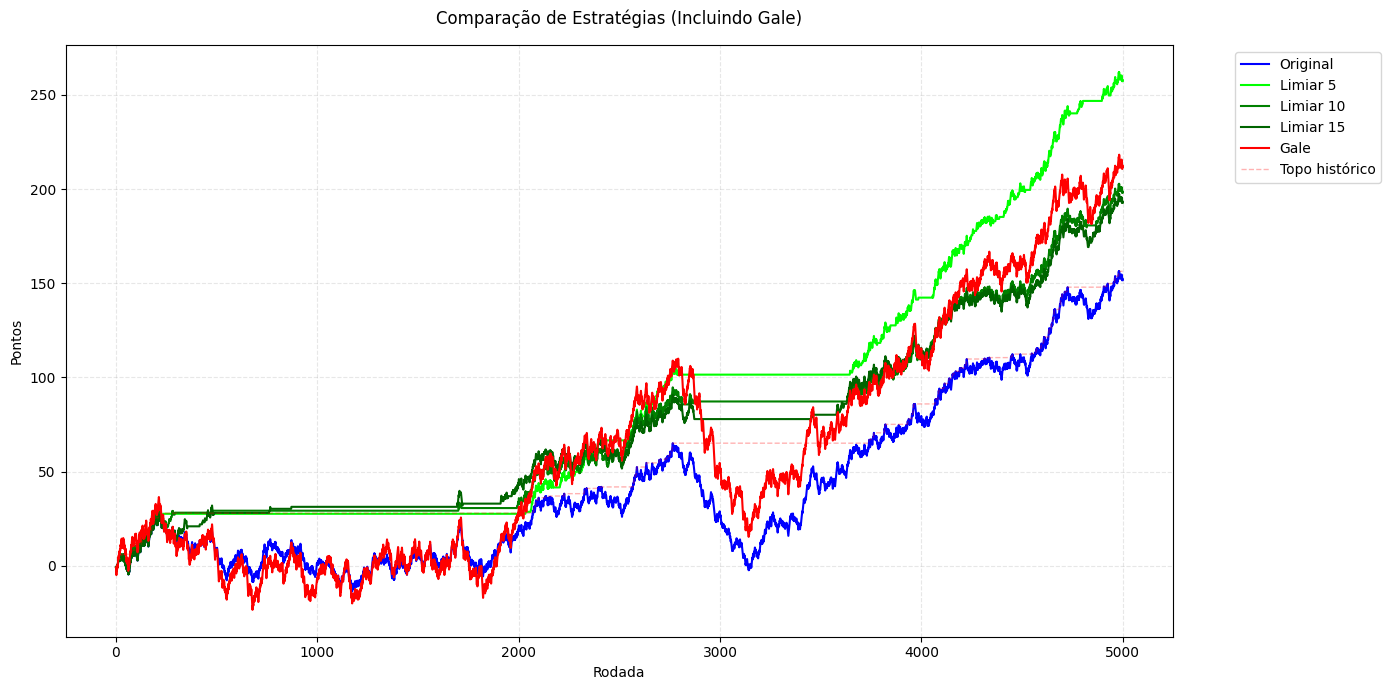

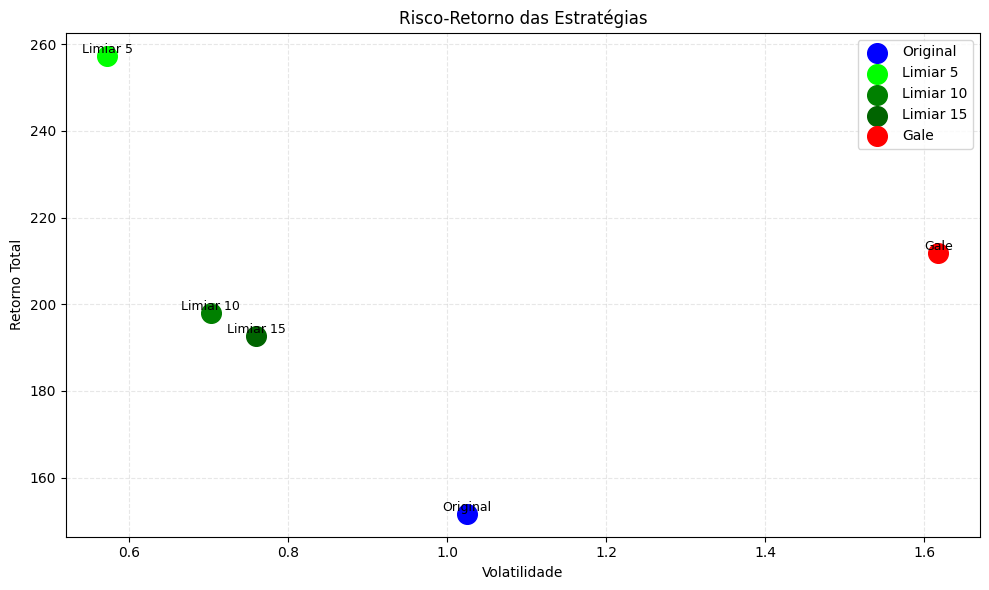

In [2]:
import secrets
import matplotlib.pyplot as plt
import numpy as np

# Configurações
num_rodadas = 5000
ponto_cara = 1.05
ponto_coroa = -1

# Inicialização
pontos = 0
evolucao_pontos = []
topo_historico = []

# Estratégias
estrategias = {
    'Original': {'pontos': 0, 'evolucao': [], 'cor': 'blue'},
    'Limiar 5': {'pontos': 0, 'evolucao': [], 'cor': 'lime'},
    'Limiar 10': {'pontos': 0, 'evolucao': [], 'cor': 'green'},
    'Limiar 15': {'pontos': 0, 'evolucao': [], 'cor': 'darkgreen'},
    'Gale': {'pontos': 0, 'evolucao': [], 'cor': 'red', 'ultima_perda': False}
}

# Simulação
for rodada in range(num_rodadas):
    # Jogo original
    resultado = secrets.SystemRandom().random()
    pontos += ponto_cara if resultado < 0.5 else ponto_coroa
    evolucao_pontos.append(pontos)
    topo_historico.append(max(topo_historico[-1], pontos) if rodada > 0 else pontos)

    # Atualização das estratégias
    for nome, dados in estrategias.items():
        if nome == 'Original':
            dados['pontos'] = pontos
            dados['evolucao'].append(pontos)
            continue

        if nome == 'Gale':
            # Estratégia Gale (Martin Gale)
            if dados['ultima_perda']:
                # Dobra a aposta após uma perda
                dados['pontos'] += ponto_cara * 2 if resultado < 0.5 else ponto_coroa * 2
                dados['ultima_perda'] = (resultado >= 0.5)
            else:
                # Aposta normal
                dados['pontos'] += ponto_cara if resultado < 0.5 else ponto_coroa
                dados['ultima_perda'] = (resultado >= 0.5)
            dados['evolucao'].append(dados['pontos'])
            continue

        # Estratégias com limiar
        limiar = int(nome.split()[-1])
        diferenca = topo_historico[-1] - pontos

        if diferenca <= limiar:
            dados['pontos'] += ponto_cara if resultado < 0.5 else ponto_coroa

        dados['evolucao'].append(dados['pontos'])

# Gráfico 1: Comparação de Linhas
plt.figure(figsize=(14, 7))
for nome, dados in estrategias.items():
    plt.plot(dados['evolucao'], color=dados['cor'], label=nome, linewidth=1.5)

plt.plot(topo_historico, 'r--', label='Topo histórico', linewidth=1, alpha=0.3)
plt.title('Comparação de Estratégias (Incluindo Gale)', pad=15)
plt.xlabel('Rodada')
plt.ylabel('Pontos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 2: Risco-Retorno
retornos = [estrategias[nome]['evolucao'][-1] for nome in estrategias]
volatilidades = [np.std(np.diff(estrategias[nome]['evolucao'])) for nome in estrategias]

plt.figure(figsize=(10, 6))
for i, nome in enumerate(estrategias):
    plt.scatter(volatilidades[i], retornos[i], s=200,
               color=estrategias[nome]['cor'], label=nome)
    plt.text(volatilidades[i], retornos[i], nome,
            fontsize=9, ha='center', va='bottom')

plt.title('Risco-Retorno das Estratégias')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Total')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

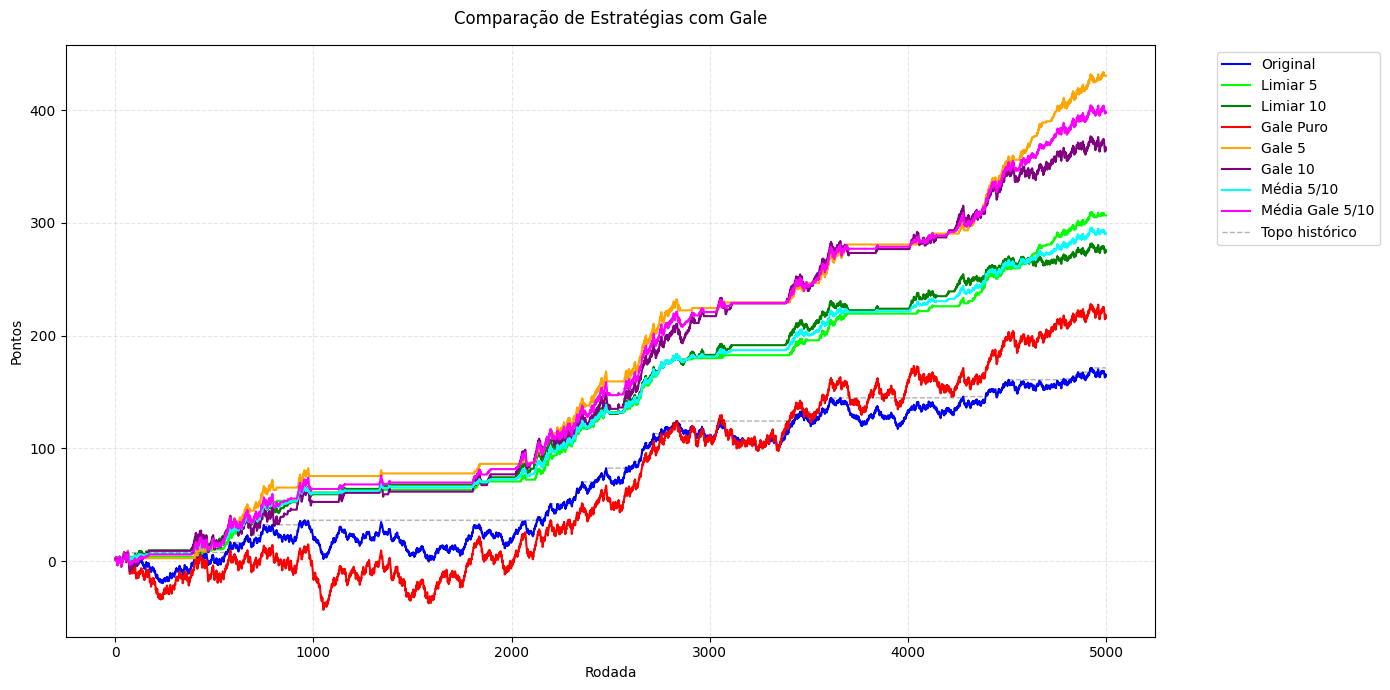

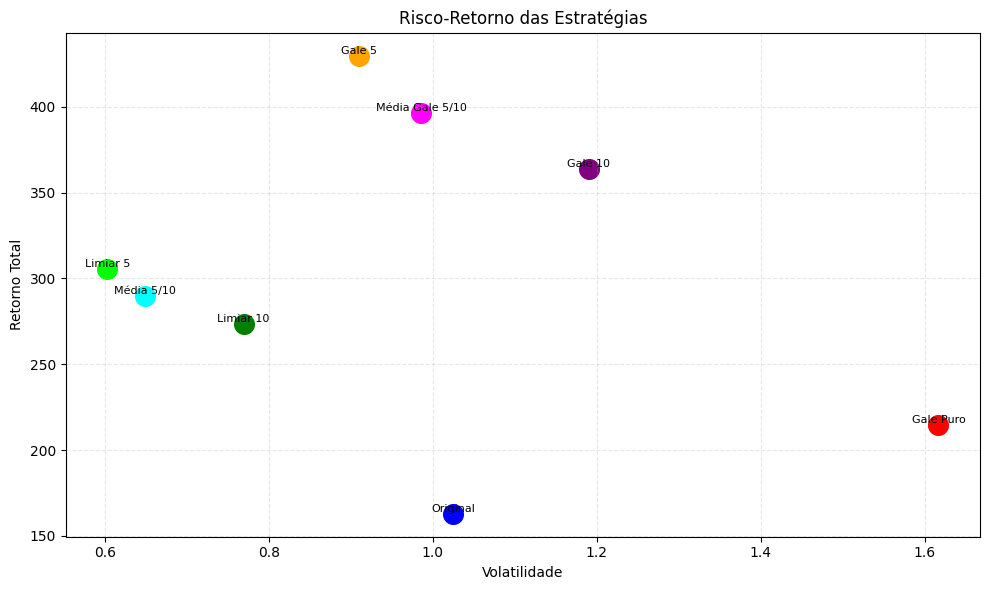

In [1]:
import secrets
import matplotlib.pyplot as plt
import numpy as np

# Configurações
num_rodadas = 5000
ponto_cara = 1.05
ponto_coroa = -1

# Inicialização
pontos = 0
evolucao_pontos = []
topo_historico = []

# Estratégias
estrategias = {
    'Original': {'pontos': 0, 'evolucao': [], 'cor': 'blue'},
    'Limiar 5': {'pontos': 0, 'evolucao': [], 'cor': 'lime'},
    'Limiar 10': {'pontos': 0, 'evolucao': [], 'cor': 'green'},
    'Gale Puro': {'pontos': 0, 'evolucao': [], 'cor': 'red', 'ultima_perda': False},
    'Gale 5': {'pontos': 0, 'evolucao': [], 'cor': 'orange', 'ultima_perda': False},
    'Gale 10': {'pontos': 0, 'evolucao': [], 'cor': 'purple', 'ultima_perda': False}
}

# Simulação
for rodada in range(num_rodadas):
    # Jogo original
    resultado = secrets.SystemRandom().random()
    pontos += ponto_cara if resultado < 0.5 else ponto_coroa
    evolucao_pontos.append(pontos)
    topo_historico.append(max(topo_historico[-1], pontos) if rodada > 0 else pontos)

    # Atualização das estratégias
    for nome, dados in estrategias.items():
        if nome == 'Original':
            dados['pontos'] = pontos
            dados['evolucao'].append(pontos)
            continue

        # Estratégias Gale
        if 'Gale' in nome:
            aplicar_gale = True
            # Verifica se está dentro do limiar para as estratégias com limiar
            if nome in ['Gale 5', 'Gale 10']:
                limiar = int(nome.split()[-1])
                diferenca = topo_historico[-1] - pontos
                aplicar_gale = (diferenca <= limiar)

            if aplicar_gale:
                if dados['ultima_perda']:
                    dados['pontos'] += ponto_cara * 2 if resultado < 0.5 else ponto_coroa * 2
                    dados['ultima_perda'] = (resultado >= 0.5)
                else:
                    dados['pontos'] += ponto_cara if resultado < 0.5 else ponto_coroa
                    dados['ultima_perda'] = (resultado >= 0.5)
            else:
                dados['pontos'] += 0  # Fora do limiar, não opera

            dados['evolucao'].append(dados['pontos'])
            continue

        # Estratégias com limiar simples
        limiar = int(nome.split()[-1])
        diferenca = topo_historico[-1] - pontos

        if diferenca <= limiar:
            dados['pontos'] += ponto_cara if resultado < 0.5 else ponto_coroa

        dados['evolucao'].append(dados['pontos'])

# Cálculo das médias
media_limiares = np.mean([estrategias['Limiar 5']['evolucao'], estrategias['Limiar 10']['evolucao']], axis=0)
media_gale_limiares = np.mean([estrategias['Gale 5']['evolucao'], estrategias['Gale 10']['evolucao']], axis=0)

estrategias['Média 5/10'] = {'evolucao': media_limiares.tolist(), 'cor': 'cyan'}
estrategias['Média Gale 5/10'] = {'evolucao': media_gale_limiares.tolist(), 'cor': 'magenta'}

# Gráfico 1: Comparação de Linhas
plt.figure(figsize=(14, 7))
for nome in ['Original', 'Limiar 5', 'Limiar 10', 'Gale Puro', 'Gale 5', 'Gale 10', 'Média 5/10', 'Média Gale 5/10']:
    dados = estrategias[nome]
    plt.plot(dados['evolucao'], color=dados['cor'], label=nome, linewidth=1.5)

plt.plot(topo_historico, 'k--', label='Topo histórico', linewidth=1, alpha=0.3)
plt.title('Comparação de Estratégias com Gale', pad=15)
plt.xlabel('Rodada')
plt.ylabel('Pontos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 2: Risco-Retorno
plt.figure(figsize=(10, 6))
for nome in ['Original', 'Limiar 5', 'Limiar 10', 'Gale Puro', 'Gale 5', 'Gale 10', 'Média 5/10', 'Média Gale 5/10']:
    dados = estrategias[nome]
    retorno = dados['evolucao'][-1] - dados['evolucao'][0]
    volatilidade = np.std(np.diff(dados['evolucao']))
    plt.scatter(volatilidade, retorno, s=200, color=dados['cor'], label=nome)
    plt.text(volatilidade, retorno, nome, fontsize=8, ha='center', va='bottom')

plt.title('Risco-Retorno das Estratégias')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Total')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()